In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
res = 'run_v1/csv_results/'

In [3]:
df = pd.read_parquet(res + 'all.parquet')

In [4]:
df

,value,distance,amount,s_exp,source
0,0.0,3706.6,76.64,1.816492,route_11_evening_shortest
1,5.0,515.5,10.66,1.816492,route_11_evening_shortest
2,7.0,284.4,5.88,1.816492,route_11_evening_shortest
3,16.0,132.8,2.74,1.816492,route_11_evening_shortest
4,4.0,114.7,2.37,1.816492,route_11_evening_shortest
...,...,...,...,...,...
20,71.0,17.4,0.24,91.054361,route_9_noon_recommended
21,93.0,14.3,0.20,91.054361,route_9_noon_recommended
22,87.0,9.1,0.13,91.054361,route_9_noon_recommended
23,28.0,7.0,0.10,91.054361,route_9_noon_recommended


In [5]:
df['route_id'] = df['source'].str.split('_').str[1]
df['route_id'] = df['source'].str.split('_').str[1]
df['time_day'] = df['source'].str.split('_').str[2]
df['type'] = df['source'].str.split('_').str[3]
df

,value,distance,amount,s_exp,source,route_id,time_day,type
0,0.0,3706.6,76.64,1.816492,route_11_evening_shortest,11,evening,shortest
1,5.0,515.5,10.66,1.816492,route_11_evening_shortest,11,evening,shortest
2,7.0,284.4,5.88,1.816492,route_11_evening_shortest,11,evening,shortest
3,16.0,132.8,2.74,1.816492,route_11_evening_shortest,11,evening,shortest
4,4.0,114.7,2.37,1.816492,route_11_evening_shortest,11,evening,shortest
...,...,...,...,...,...,...,...,...
20,71.0,17.4,0.24,91.054361,route_9_noon_recommended,9,noon,recommended
21,93.0,14.3,0.20,91.054361,route_9_noon_recommended,9,noon,recommended
22,87.0,9.1,0.13,91.054361,route_9_noon_recommended,9,noon,recommended
23,28.0,7.0,0.10,91.054361,route_9_noon_recommended,9,noon,recommended


In [6]:
dfw = df.groupby('source')['distance'].sum()

dfw = dfw.to_frame().reset_index()



In [7]:
df_exp = df[['source', 's_exp', 'time_day']]
df_exp = df_exp.drop_duplicates()

In [8]:
df_exp

,source,s_exp,time_day
0,route_11_evening_shortest,1.816492,evening
0,route_11_afternoon_shortest,3.695904,afternoon
0,route_15_evening_recommended,31.751592,evening
0,route_17_morning_recommended,1.212506,morning
0,route_17_noon_shortest,98.064085,noon
...,...,...,...
0,route_18_morning_shortest,9.280200,morning
0,route_5_morning_recommended,63.345482,morning
0,route_18_noon_shortest,81.004873,noon
0,route_13_noon_recommended,40.550386,noon


In [9]:
df_merged = dfw.merge(df_exp[['source', 's_exp', 'time_day']], on='source', how='inner')

df_merged['route_type'] = df_merged['source'].str.split('_').str[3]

df_merged

,source,distance,s_exp,time_day,route_type
0,route_0_afternoon_recommended,8425.7,64.060731,afternoon,recommended
1,route_0_afternoon_shortest,8291.9,65.256515,afternoon,shortest
2,route_0_evening_recommended,8412.3,50.523876,evening,recommended
3,route_0_evening_shortest,8388.8,49.939801,evening,shortest
4,route_0_morning_recommended,7967.6,5.663311,morning,recommended
...,...,...,...,...,...
155,route_9_evening_shortest,7197.4,73.508628,evening,shortest
156,route_9_morning_recommended,7163.9,7.079775,morning,recommended
157,route_9_morning_shortest,7092.4,7.083879,morning,shortest
158,route_9_noon_recommended,7240.5,91.054361,noon,recommended


In [10]:
import pandas as pd
import seaborn as sns
import numpy as np

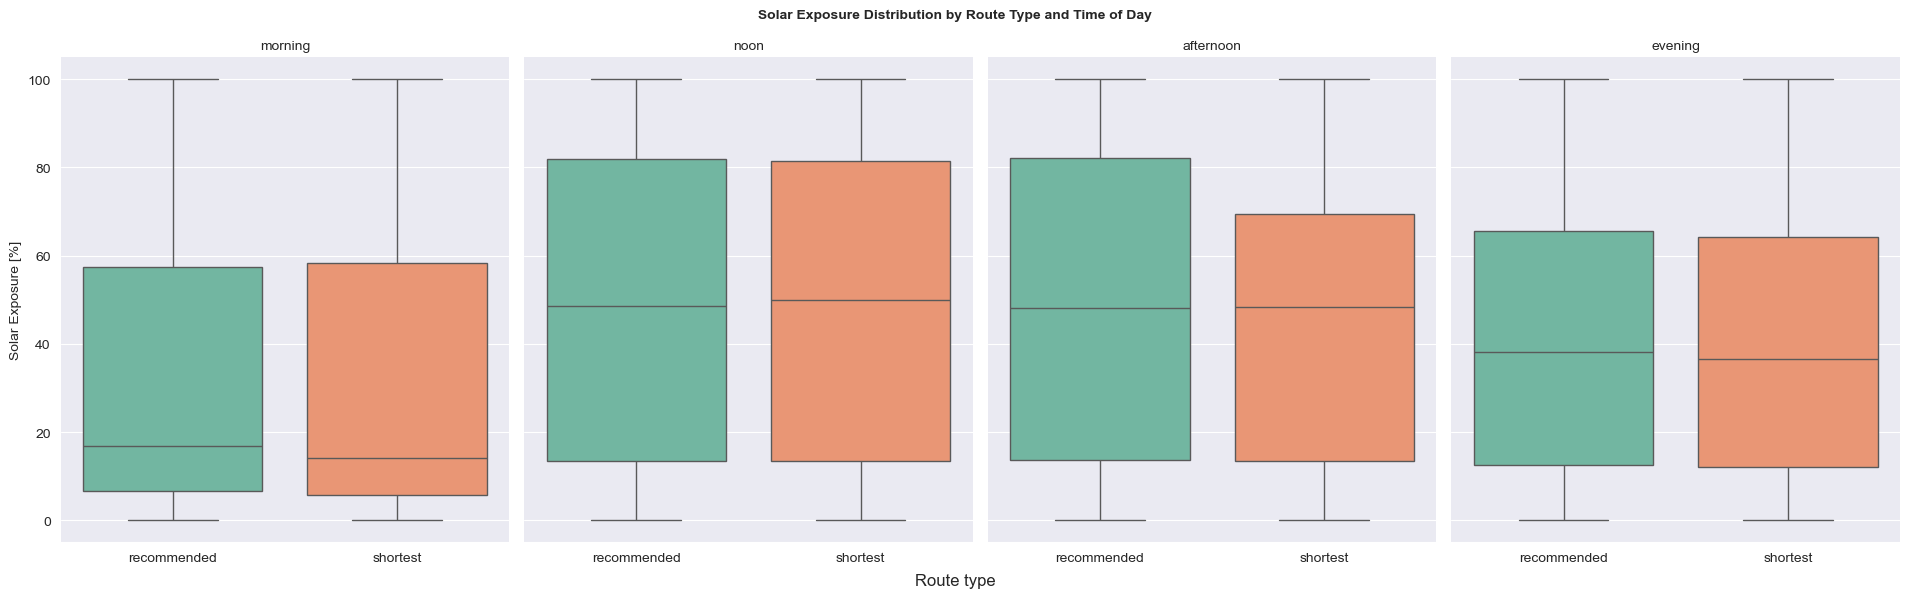

In [11]:
palette = sns.color_palette("Set2", 2)

p = sns.catplot(
    kind='box',
    data=df_merged,
    x='route_type',
    y='s_exp',
    hue='route_type',
    legend=False,
    col='time_day',
    col_wrap=4,
    height=6,
    aspect=0.8,
    palette=palette,
    col_order=['morning', 'noon', 'afternoon', 'evening']
)


p.set_titles("{col_name}")
p.set_axis_labels("", "Solar Exposure [%]")
p.despine(left=True)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Solar Exposure Distribution by Route Type and Time of Day", fontsize=10, fontweight='bold')


p.fig.text(0.5, 0.02, "Route type", ha='center', fontsize=12)

p.savefig("s_exp_route_type_timeofday.png", dpi=400, bbox_inches='tight')

plt.show()